In [1]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)

libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)

    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldings
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../price_data_utils/prices', info_dir='../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../price_data_utils/cached')
dl.load_data()
data = dl.data

Prediction Date: 2019-08-09


In [3]:
hp = HistoricalPrices(prices_dir='../price_data_utils/prices', 
                      cached_dir='../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [4]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [5]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')

In [6]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [7]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [8]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [9]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


In [10]:
# create a risk model for 2011 data
returns_2011 = returns.loc[returns.index.year == 2011]
print(returns_2011.shape)
returns_2011.head()

(249, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,0.008666,0.015779,0.000000,-0.018090,0.037116,0.045433,-0.007356,0.006471,-0.005972,-0.003648,...,-0.008942,-0.022368,-0.018391,0.000519,0.000635,0.002047,0.002190,-0.016205,-0.010781,-0.007082
2011-01-07,0.000954,0.007767,-0.008134,-0.004764,0.023316,-0.002120,0.000303,-0.000946,0.002939,0.016846,...,-0.010526,-0.011045,-0.009368,-0.003628,-0.001903,0.003064,-0.012568,-0.019949,-0.008266,-0.009384
2011-01-10,-0.008583,0.009634,0.001548,0.015632,0.020146,0.005463,0.011035,0.012493,-0.002039,0.003842,...,-0.022290,-0.007047,-0.011032,0.006502,0.032627,0.021725,0.000554,0.031186,0.014918,-0.001516
2011-01-11,0.004328,-0.019466,0.007415,0.034649,0.002587,0.008603,0.024671,0.009348,0.032695,0.004783,...,-0.001554,0.021693,-0.009960,0.005168,0.015183,-0.003987,-0.011615,-0.015031,0.011770,0.000759
2011-01-12,0.011494,0.008174,0.021469,0.004342,0.018779,-0.010175,0.002043,0.005927,0.013975,0.014044,...,-0.002076,0.005898,-0.003622,0.013419,0.014956,0.006004,0.019026,0.011583,0.002171,0.008722


In [11]:
risk_model = RiskModelPCA(returns_2011, 20)

<Container object of 20 artists>

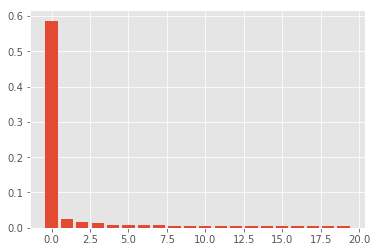

In [12]:
plt.bar(np.arange(risk_model.n_components), risk_model.pca.explained_variance_ratio_)

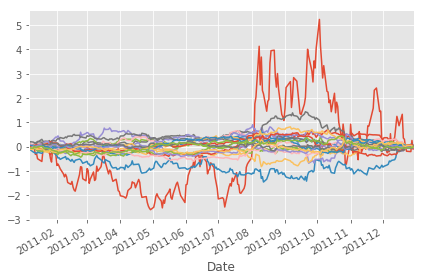

In [13]:
# looking at factor returns
risk_model.factor_returns.cumsum().plot(legend=False)
plt.tight_layout()

In [14]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()

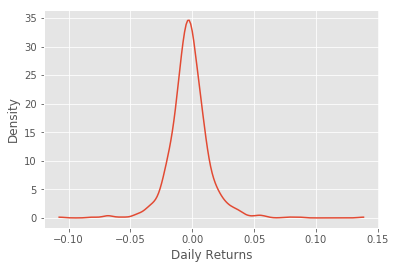

In [15]:
density_plot(risk_model.unwinz_returns.iloc[0])

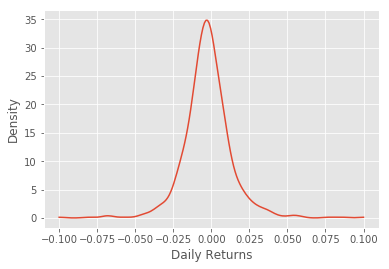

In [16]:
density_plot(risk_model.returns.iloc[0])

In [17]:
holdings = [50000000 / len(returns_2011.columns)] * len(returns_2011.columns)
holdings[:5]

[67476.38326585694,
 67476.38326585694,
 67476.38326585694,
 67476.38326585694,
 67476.38326585694]

In [18]:
risk_model.predict_portfolio_risk(holdings)

186099218691818.44

In [19]:
risk_model.predict_portfolio_risk_opt(holdings)

186099218691818.47

In [20]:
holdings = [1.0 / len(returns_2011.columns)] * len(returns_2011.columns)
holdings[:5]

[0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139]

In [21]:
np.sqrt(risk_model.predict_portfolio_risk(holdings))

0.27283637491494306

In [22]:
np.sqrt(risk_model.predict_portfolio_risk_opt(holdings))

0.27283637491494295

In [23]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [24]:
momentum = create_momentum_factor(p, sector_data)
momentum.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [25]:
risk_model.returns.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-23,0.018753,-0.020237,0.011614,0.021882,-0.001494,0.001786,0.008702,0.024272,-0.005726,0.008050,...,0.011543,0.000939,0.000381,0.009111,0.004898,0.008929,0.013871,0.036691,0.016639,0.003724
2011-12-27,0.005956,-0.032746,-0.001218,0.012695,-0.004059,-0.002773,0.003299,0.008989,-0.002399,0.011224,...,0.010373,0.000402,0.013318,-0.008482,0.004874,0.006110,-0.001244,0.007106,-0.003195,0.005059
2011-12-28,-0.022605,-0.013021,-0.019680,-0.012450,-0.009119,-0.017680,-0.019558,-0.014253,-0.019243,-0.020704,...,-0.006673,-0.018226,-0.015020,-0.009106,-0.013743,0.002304,-0.005604,-0.015604,-0.007872,-0.003691
2011-12-29,0.004956,-0.005805,0.019009,0.018200,0.028328,0.001415,0.019430,0.011173,0.018476,0.023104,...,0.011886,0.012012,0.012581,0.029518,0.012295,0.012954,0.028178,-0.009786,0.016776,0.002021
2011-12-30,-0.009315,0.001592,-0.007148,-0.006480,0.001460,-0.017569,-0.005845,-0.008125,-0.004655,-0.004900,...,-0.003575,-0.001214,-0.006777,0.003787,-0.000810,0.001857,-0.016444,-0.000696,-0.006466,-0.011092


In [26]:
date_ = pd.to_datetime('2011-12-30')
date_

Timestamp('2011-12-30 00:00:00')

In [27]:
alpha_vector = momentum.loc['2012-01-05', :]
len(alpha_vector)

741

In [28]:
previous = holdings

In [29]:
oh = OptimalHoldings(risk_model, alpha_vector, previous)

In [30]:
oh._get_obj()

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [31]:
risk_model.Q.shape

(20, 741)